# Review text analysis

In [128]:
# import the required libraries here
# two lines of code here:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud

In [95]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
reviews = pd.read_csv('reviews_filtered.csv')

Let's remind ourselves what our review DataFrame looked like, and check we're reading it in as expected.

In [3]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,JA-xnyHytKiOIHl_ztnK9Q,P6apihD4ASf1vpPxHODxAQ,e_BiI4ej1CW1F0EyVLr-FQ,5,0,0,0,Most delicious authentic Italian I've had in t...,2015-02-16 06:48:47
1,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4,0,0,0,"In the heart of Chinatown, I discovered it enr...",2017-06-06 19:04:10
2,09qxjFi4abaW66JeSLazuQ,mbdtyUUzZZx5ld1Qc4iGtQ,wkzWdo1mBqbzR2KPoXtWZw,4,1,0,0,Was a Chicago style deep dish. Homemade type ...,2010-08-21 01:19:17
3,K-wdPGHbErfxbKK6PetrmA,FCoXqPxuI7GRBYyzJIwVxw,r4HkiC71nB9k8Fe8zIORFQ,5,1,0,1,First time eating there and everything was so ...,2015-12-05 02:16:06
4,nAm92_-WUQ084x9Uz9iFmA,iFEM16O5BeKvf_AHs6NzUQ,9Eghhu_LzEJgDKNgisf3rg,3,0,0,0,Was super excited to bring my boyfriend to thi...,2016-08-25 16:25:12


We see the first review wasn't great, at two stars, but the second got five stars. Let's have a quick look at the full text for each.

## A two star review

In [4]:
reviews.loc[0, 'text']

"Most delicious authentic Italian I've had in the US. You wouldn't leave this place unhappy. The setting is cozy and a perfect spot for VD, anniversaries, or a special date. They'll make you feel like you're in Italy."

This review does appear somewhat lukewarm, at best. On another note, we can see it talks about pizza and italian, which is some reassurance we made a good decision to combine the pizza and italian categories.

## A five star review

In [5]:
reviews.loc[1, 'text']

'In the heart of Chinatown, I discovered it enroute to Kensington Market one day. It\'s quite hard to see, if you don\'t know it\'s there. First experience was very positive - would definitely return!\n\nATMOSPHERE: Small space. Think Banh Mi Boys, and other trendy over-the-counter eateries. Vibe is casual. Free WiFi is nice.\n\nSERVICE: Okay. Staff does their job, but not overly helpful upon entering the space. Maybe because it\'s an over-the-counter style place, but it would have been nice to be walked through their ordering process and menu.\n\nPRICE: Average. Depends on the size of pizza you order.The small pizza ($7-9.50) is filling for one. Large size pizza ($13-18.50) is good for sharing... or one VERY hungry person.  Pasta portions are very generous for the price tag ($9-14)\n\n\nFOOD: My friends and I were here for the first time, and we thought it was a pizza place so we all ordered pizza. It wasn\'t until we were waiting for the food to come, that we looked around and realis

This certainly seems to be a good review. We'd be happy to see our restaurant associated with "cool atmosphere", "all around great experience" etc.

## Good and bad reviews
We don't want to have to read all the reviews in our dataset in order to find good and bad ones. Clearly 5 is best and 1 is worst, but how do we group them? Do we set a threshold in the middle, or just take the top and bottom ratings? Let's first see what the distribution of ratings looks like.

In [6]:
reviews['stars'].describe()

count    712958.000000
mean          3.725480
std           1.424354
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64

In [7]:
star_counts = reviews['stars'].value_counts()

In [14]:
star_counts.head

<bound method NDFrame.head of 5    301892
4    168366
1     95417
3     83204
2     64079
Name: stars, dtype: int64>

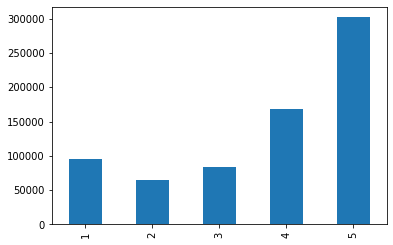

In [15]:
# task: create a bar plot of number of reviews for each star rating
# hint: sort_index may be useful to get your x-axis in the most intuitive order
star_counts.sort_index().plot(kind='bar')

This is useful. It seems reviews with three stars or fewer are in the bottom quartile and reviews with five stars are in the top quartile. We could take five stars as being a single, best category, and three stars and fewer as being 'not good'.

## Visualizing reviews
From our analysis of the distribution of review star ratings, our first approach to delivering an answer to the marketing team will be to look at the most popular words in the best reviews and compare them with those in the worst reviews.

First, let's extract the good and bad reviews separately.

In [135]:
# task, filter the 'text' column using the 'stars' column to create Series of good and bad review text
# call the results good_review_text and bad_review_text, respectively
# two lines of code here:
good_review_text = reviews.loc[reviews['stars'] == 5, 'text']                                              
bad_review_text = reviews.loc[reviews['stars'] <= 1, 'text']

In [86]:
bad_review_text

4         Was super excited to bring my boyfriend to thi...
5         More than just  Pizza. This location is small ...
6         I ordered a pizza at 4:49. Got an email that s...
12        the most low quality catering in persian catag...
14        This is not the place for Italian food.  It is...
                                ...                        
712950    My wife and I have eaten at La Brioche at leas...
712951    Horrible customer service and service in gener...
712953    First let me say Lindys in Columbus is one of ...
712955    Pepperoni Roll- From back east and had a cravi...
712957    After making reservations more than 3 weeks pr...
Name: text, Length: 242700, dtype: object

We can now double check how many rows we have, and that they seem to agree with the numbers of reviews we'd expect from the distribution of stars ratings above.

In [32]:
good_review_text.shape

(301892,)

In [136]:
bad_review_text.shape

(95417,)

Now that's actually quite a lot of reviews. For our purposes here, we'll start by just selecting the first 1000 reviews from each group on the assumption that they're randomly ordered. We'll also add a slight tidying step of converting the characters to lower case so we don't count 'Bad' and 'bad', for example, separately.

In [137]:
# task: select the first 1000 items in each of the good and bad review text Series and chain the
# str.lower() method to convert characters to lower case. Save the results back in place.
# two lines of code here:
good_review_text = good_review_text.iloc[0:1000].str.lower()
bad_review_text = bad_review_text.iloc[0:1000].str.lower()

In [138]:
bad_review_text

6       i ordered a pizza at 4:49. got an email that s...
12      the most low quality catering in persian catag...
16      seriously, where are the vegetarian options? a...
25      really filthy silverware asked for new set  ju...
29      if i could i could give 0 stars i would. so we...
                              ...                        
8455    i ordered 3 well done & thin pizzas. one chees...
8471    service was horrible. main courses were horrib...
8477    we just ate here with a group of six. we're fr...
8498    it's been a long time since i've walked out on...
8499    overpaid dramatically for the terrible sandwic...
Name: text, Length: 1000, dtype: object

In [90]:
# Check first few good reviews
good_review_text.head()

0    most delicious authentic italian i've had in t...
3    first time eating there and everything was so ...
7    their homemade lasagna was great!\nyou've gott...
8    by far my favorite italian restaurant in vegas...
9    i saw big jim's on diners, drive-ins and dives...
Name: text, dtype: object

In [91]:
# check first few bad reviews
bad_review_text.head()

4     was super excited to bring my boyfriend to thi...
5     more than just  pizza. this location is small ...
6     i ordered a pizza at 4:49. got an email that s...
12    the most low quality catering in persian catag...
14    this is not the place for italian food.  it is...
Name: text, dtype: object

So far, we've partitioned our reviews into groups we think of as 'great' and 'bad'. Our problem now is how to make sense of this. How do we interpret, or visualise, the information? A great way to get a visual look at how frequently certain words occur is by a wordcloud. A nice introduction to creating wordclouds is [here](https://www.datacamp.com/community/tutorials/wordcloud-python) in a DataCamp community article. You'll likely want to pay attention to the step for installing the relevant library in order to get the next import statement to work.

In [97]:
# task: import WordCloud and STOPWORDS here
# one line of code here
from wordcloud import WordCloud, STOPWORDS

We first need to gather the reviews into a single corpus, for each of good and bad reviews, for wordcloud.

In [139]:
# task: combine all the good and bad review text into a single string for each
# two lines of code here
good_text = ' '.join(good_review_text)
bad_text = ' '.join(bad_review_text)

In [140]:
bad_text

'i ordered a pizza at 4:49. got an email that said my pizza would be delivered at 5:18 to5:28. 5:38 still no pizza. called the store. they said it was out for delivery. i said i knew that it was suppose to be delivered 10 minutes ago. 5:48. still no pizza. called the store back. again, i was told it was out for delivery. 5:48 called the store again. when i was on the phone the pizza came. when it arrived it was cold. the most low quality catering in persian catagory. we had party on persian new year and every one paid for the food to be cater through this place.\nthe food was not even enough for everybody and the quality was bad.\ni feel so bad for this business, seriously, where are the vegetarian options? all the dishes (even the salads) have either meat, fish, poultry or eggs in them. i have heard that this place is good from my friends but i can\'t join them since there is nothing for vegetarian or vegan people to eat here. vegetarianism is becoming more popular everyday and restau

### Good wordcloud

Now, at last, we can create a wordcloud! Let's look at the top 50 words from the best reviews.

In [130]:
# task: generate a wordcloud of good review words, max 50 words
# one line of code here, call the result good_wordcloud
good_wordcloud = WordCloud(max_words=50).generate(good_text)

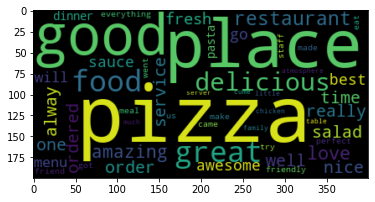

In [131]:
plt.imshow(good_wordcloud, interpolation='bilinear')

This is great! It looks sensible. In fact, someone from marketing just walked past your screen and already is interested in taking this image as it is and using it! They're so excited they would like a copy of that image to test in laying out their new marketing designs.

In [154]:
# task: use the to_file method for wordcloud to save the above image to send to marketing
# one line of code here
good_wordcloud.to_file("goodd_reviews.jpeg")

### Bad wordcloud

Can we learn anything extra from looking at the top words in bad reviews?

In [141]:
# task: generate a wordcloud of bad review words, max 50 words
# one line of code here, call the result bad_wordcloud
bad_wordcloud = WordCloud(max_words=50).generate(bad_text)

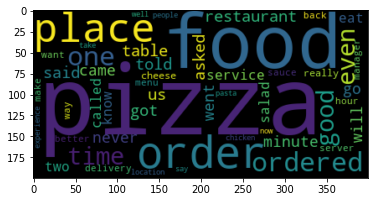

In [142]:
plt.imshow(bad_wordcloud, interpolation='bilinear')

We notice some things here. Firstly, 'pizza' is a very prominent word, but it was in the top reviews as well. It's very obviously a relevant word for our target category, but is it useful in separating good and bad reviews? Probably not. We can also start to make some interesting observations that there seem to be more "dull" words here, such as "told", "said", "came", and "went". There is clearly a different tone between our two wordclouds. We've definitely achieved something useful here.

# Summary
Congratulations! You've achieved a lot since starting this project. You've related a business problem to a dataset and identified which data you needed. You've drilled into that data to answer an initial question of which food category the business should target. Then you've used knowledge gained from that to extract just the related reviews from a large file that, otherwise, would be too large to handle. You've further teased apart the best and the worst reviews to look at them separately and clearly seen there is a difference.

You already have a useful output, but you know that there's more that can be done. The rest of the notebook is entirely optional and gives some ideas for how you might refine what you've already done.

# Towards a better wordcloud

Having seen that some words that occur prominently in bad reviews were also in our good reviews, we can exclude these from our wordcloud by specifying them as stopwords. Let's add them to the list of default stopwords STOPWORDS.

In [145]:
bad_stopwords = set(['pizza', 'food', 'order', 'place'])

In [146]:
# task: create a set of stopwords and add the "bad" ones above to it
# two lines of code here:
stopwords = set(STOPWORDS)
stopwords.update(bad_stopwords)

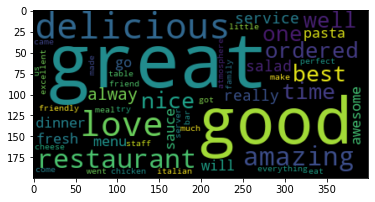

In [147]:
# task: generate a better wordcloud of good review words, max 50 words
# one line of code here, call the result better_wordcloud
better_wordcloud = WordCloud(stopwords=stopwords, max_words=50).generate(good_text)
plt.imshow(better_wordcloud, interpolation='bilinear')

Hopefully you can see we've now excluded some words. We'll leave it up to you and your marketing team whether you prefer the above version!

# Beyond words
The use of single words is a good start, but words occur in sequences and sequences can have much additional meaning. Consider a good review that said "Highly recommended" and a bad review that said "Not recommended". Analysing just single words, we would lose the "highly recommended" tag. What's more, with the approach of looking for words in good reviews that aren't in bad reviews, we would lose the word "recommended" entirely. Using sequences of two words, or bi-grams as they're known, would tackle this issue. Generally, in fact, we can consider n-grams.